# Felipe Cadar Chamone - Projeto Final

## Estimando Correspondências entre Imagens

In [1]:
import torch
import numpy as np
import scipy.spatial
from tqdm import tqdm
import cv2, os
import utils.io, utils.hpatches, utils.features
import matplotlib.pyplot as plt
import time

In [2]:
# Making the Dataset

# Extracting Features
viewpoint_data = utils.hpatches.getViewpoint()
illumination_data = utils.hpatches.getIlumination()
# raw_data = {'viewpoint': viewpoint_data, 'illumination': illumination_data}
raw_data = {'viewpoint': viewpoint_data}
data_path = './data'
extractor_name = 'sift'

os.makedirs(data_path, exist_ok=True)

extractor = cv2.SIFT_create(1024)
match_theashold = 2
plot_examples = False

plot_limit = 0
for data_type in raw_data:
    for data_name in tqdm(raw_data[data_type]):
        paths = sorted(raw_data[data_type][data_name])
        
        master_path = paths[0]
        master_id = master_path.split("/")[-1].split(".")[0]
        master_result_path = os.path.join(data_path, f"{extractor_name}/{data_name}/{master_id}")
        
        if not (os.path.isfile(master_result_path+".kps")) or not (os.path.isfile(master_result_path+".desc.npz")):
            master_img = cv2.imread(master_path)
            master_kps, master_desc = extractor.detectAndCompute(master_img, None)
            os.makedirs(os.path.dirname(master_result_path), exist_ok=True)

            utils.io.writeCvKps(master_kps, master_result_path)
            utils.io.writeDesc(master_desc, master_result_path)
        else:
            master_kps = utils.io.readKps(master_result_path + '.kps')
            master_desc = np.load(master_result_path + '.desc.npz')['desc']
        
        for image_path in paths[1:]:
            plot_limit+=1


            
            img_id = image_path.split("/")[-1].split(".")[0]
            result_path = os.path.join(data_path, f"{extractor_name}/{data_name}/{img_id}")

            if not (os.path.isfile(result_path+".kps")) or not (os.path.isfile(result_path+".desc.npz")):
                img = cv2.imread(image_path)
                kps, desc = extractor.detectAndCompute(img, None)
                os.makedirs(os.path.dirname(result_path), exist_ok=True)

                utils.io.writeCvKps(kps, result_path)
                utils.io.writeDesc(desc, result_path)
            else:
                kps = utils.io.readKps(result_path + '.kps')
                desc = np.load(result_path + '.desc.npz')['desc']

            
            if not os.path.isfile(result_path+'.match'):
                H = np.loadtxt(os.path.join( utils.hpatches.HPATCHES_LOCAL, "data/hpatches-sequences-release" , data_name, f"H_1_{img_id}"))
                tgt_kps_np = utils.features.cvToNp(kps)
                master_kps_np = utils.features.cvToNp(master_kps)
                tgt_kps_gt = utils.hpatches.getGT(master_kps_np, H)
                
                
                dist = scipy.spatial.distance_matrix(tgt_kps_gt, tgt_kps_np)
                src, dst = np.where(dist < match_theashold)
                match = np.concatenate([src[:, np.newaxis], dst[:, np.newaxis]], 1)
                np.savetxt(result_path+'.match', match)
            else:

                if plot_limit % 20 == 1 and plot_examples:
                    master_img = cv2.imread(master_path)
                    img = cv2.imread(image_path)
                    
                    match_np = np.loadtxt(result_path+'.match').astype(int)
                    src, dst = match_np[:, 0], match_np[:, 1]
                    match = [cv2.DMatch(i, j, 1, 1) for i, j in zip(src, dst)]


                    matched_img = cv2.drawMatches(master_img, master_kps, img, kps, match, None)
                    plt.figure(figsize=[15, 10])
                    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
                    plt.show()


100%|███████████████████████████████████████████| 59/59 [00:00<00:00, 67.66it/s]


In [3]:
## Load dataset

from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import glob
from functools import lru_cache
import random

class GraphData(Dataset):
    def __init__(self, path="./data/sift/", train=True, train_split=0.9):
        self.data_path = path
        
        self.all_matches = sorted(glob.glob(f"{path}/*/*.match", recursive=True))
        self.imgs_path = utils.hpatches.HPATCHES_LOCAL + "data/hpatches-sequences-release"
        
        random.seed(7891)
        random.shuffle(self.all_matches)
        
        limit = int(len(self.all_matches)*train_split)
        if train:
            self.all_matches = self.all_matches[:limit]
        else:
            self.all_matches = self.all_matches[limit:]
    
#         self.transform = lambda x: torch.tensor(x)
        self.transform = ToTensor()



        
    def __len__(self):
        return len(self.all_matches)
    
    @lru_cache(1)
    def getMaster(self, idx):
        tgt_path = self.all_matches[idx].split("/")[-1]
        master_path = self.all_matches[idx].replace(tgt_path, "1")
        
        cv_kps = utils.io.readKps(master_path+".kps")
        np_kps = utils.features.cvToNp(cv_kps)
        desc = np.load(master_path+".desc.npz")['desc']
        
        return np_kps, desc
        
    def __getitem__(self, idx):
        match_path = self.all_matches[idx]
        desc_path = match_path.replace(".match", ".desc.npz")
        kps_path = match_path.replace(".match", ".kps")
        
        match = np.loadtxt(match_path)
        master_kps, master_desc = self.getMaster(idx)
        tgt_kps = utils.features.cvToNp(utils.io.readKps(kps_path))
        tgt_desc = np.load(desc_path)['desc']     
        
        data_name = match_path.split("/")[-2]
        tgt_id = match_path.split("/")[-1].split(".")[0]

            
#         if len(match) == 0:
#             print("AAA")
        
        return {
            "kps1": self.transform(master_kps).float(),
            "desc1": self.transform(master_desc).float(),
            "kps2": self.transform(tgt_kps).float(),
            "desc2": self.transform(tgt_desc).float(),
            "match": torch.tensor(match).int(),
            "img1": self.imgs_path + f"/{data_name}/1.ppm",
            "img2": self.imgs_path + f"/{data_name}/{tgt_id}.ppm"
        }

In [4]:
train_dataset = GraphData(train=True)
test_dataset = GraphData(train=False)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class PositionalEncoding(nn.Module):

    def __init__(self, in_d: int, out_d: int, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(in_d, in_d)
        self.fc2 = nn.Linear(in_d, out_d)
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        
        return x

class Encoder(nn.Module):
    def __init__(self, d_model: int, nhead: int = 8, nlayers: int = 16, dropout: float = 0.1):
        super().__init__()

        dropout = 0.1
        self.fc1 = nn.Linear(d_model, d_model)
        self.pos_encoder = PositionalEncoding(2,d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_model, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        
        
    def forward(self, data):
        kps1 = data['kps1']
        desc1 = data['desc1']
        
        kps2 = data['kps2']
        desc2 = data['desc2']
        
        n1 = desc1.shape[1]
        n2 = desc2.shape[1]
        
        x1 = self.pos_encoder(kps1) + self.fc1(desc1)
        x2 = self.pos_encoder(kps2) + self.fc1(desc2)
        
#         h = torch.concat([x1, x2], 1)
#         h = self.transformer_encoder(h)
        
#         x1 = h[:, :n1, :]
#         x2 = h[:, n1:, :]

        x1 = self.transformer_encoder(x1)
        x2 = self.transformer_encoder(x2)

        mat = torch.bmm(x1, x2.transpose(1, 2))
        
        mat = torch.concat([mat, torch.zeros_like(mat[:,:,:1])], 2)
        mat = torch.concat([mat, torch.zeros_like(mat[:,:1,:])], 1)

        match12 = F.log_softmax(mat, 2)
        
        return match12
    
def makeGT(m1, match):
    np_match = match.int().cpu().numpy()
    mat = np.zeros([m1.shape[1], m1.shape[2]])
    mat[:, -1] = 1
    mat[-1, :] = 1
    mat[-1, -1] = 2
    mat[np_match[:, 0],np_match[:, 1]] = 2
    label1 = torch.tensor(mat).argmax(1)

    return label1

In [10]:
model = Encoder(128)
criterion = nn.NLLLoss()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
log_interval = 30
plot_interval = 150
plot_iter = 0
total_loss = 0
max_epochs = 10000

| epoch   0 |     0/  265 batches | lr 0.00 | ms/batch  6.95 | loss  3.34


/var/folders/8c/4vjtx4c53532tgcgnczsgk580000gn/T/ipykernel_77714/623639055.py:50: UserWarning: loadtxt: Empty input file: "./data/sift/v_charing/5.match"
  match = np.loadtxt(match_path)
/var/folders/8c/4vjtx4c53532tgcgnczsgk580000gn/T/ipykernel_77714/623639055.py:50: UserWarning: loadtxt: Empty input file: "./data/sift/v_charing/6.match"
  match = np.loadtxt(match_path)


| epoch   0 |    30/  265 batches | lr 0.00 | ms/batch 165.73 | loss 72.10
| epoch   0 |    60/  265 batches | lr 0.00 | ms/batch 178.47 | loss 72.76
| epoch   0 |    90/  265 batches | lr 0.00 | ms/batch 178.16 | loss 57.11
| epoch   0 |   120/  265 batches | lr 0.00 | ms/batch 177.21 | loss 47.56
| epoch   0 |   150/  265 batches | lr 0.00 | ms/batch 169.64 | loss 43.70


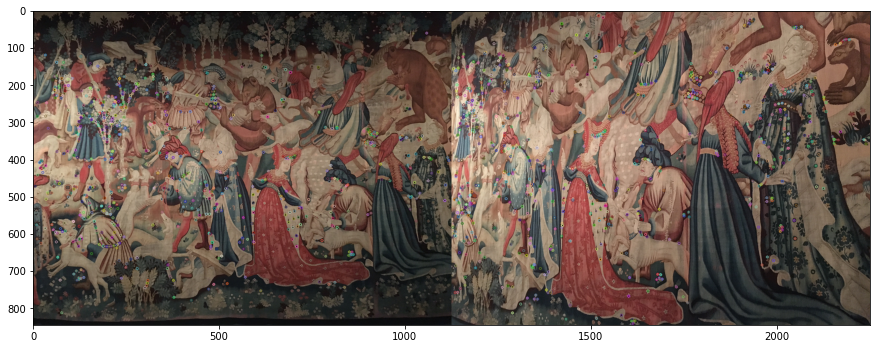

| epoch   0 |   180/  265 batches | lr 0.00 | ms/batch 193.11 | loss 41.94
| epoch   0 |   210/  265 batches | lr 0.00 | ms/batch 174.53 | loss 40.39
| epoch   0 |   240/  265 batches | lr 0.00 | ms/batch 169.48 | loss 39.13
| epoch   1 |     0/  265 batches | lr 0.00 | ms/batch 147.37 | loss 32.34
| epoch   1 |    30/  265 batches | lr 0.00 | ms/batch 167.00 | loss 35.67


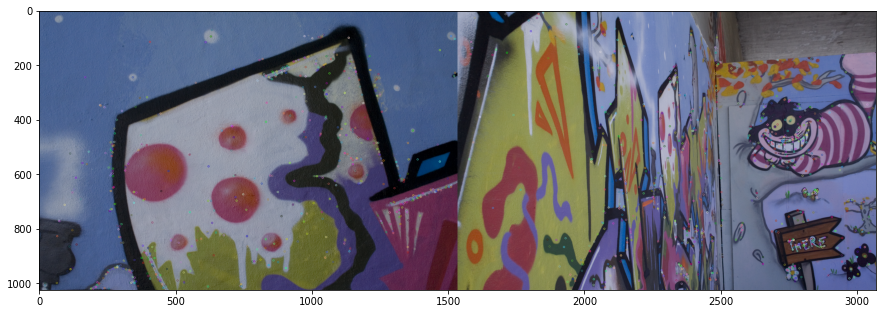

| epoch   1 |    60/  265 batches | lr 0.00 | ms/batch 190.88 | loss 37.64
| epoch   1 |    90/  265 batches | lr 0.00 | ms/batch 176.06 | loss 37.25


In [ ]:
start_time = time.time()
num_batches = len(train_dataset)
for epoch in range(max_epochs):
    for batch, d in enumerate(train_dataset):
        if len(d['match']) == 0:continue
#         if batch > 0: break
            
        y = model(d)
        label = makeGT(y, d['match'])


        loss = criterion(y.squeeze(0), label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        plot_iter += 1

        total_loss += loss.item()
        if batch % log_interval == 0:
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f}')
            total_loss = 0
            start_time = time.time()
            
        if plot_iter % plot_interval == 0:
            master_img = cv2.imread(d['img1'])
            tgt_img = cv2.imread(d['img2'])

            np_match = np.concatenate([np.arange(y.shape[1])[:, np.newaxis], y[0].argmax(1).cpu().numpy()[:, np.newaxis] ], 1)
            np_match = np_match[np_match[:, 1] != y.shape[2]-1][:-1]
            src, dst = np_match[:, 0], np_match[:, 1]
            match = [cv2.DMatch(int(i), int(j), 1, 1) for i, j in np_match]
            
            gt_match_matrix = np.zeros([d['kps1'].shape[1], d['kps2'].shape[1]], dtype=int)
            gt_match_matrix[d['match'][:, 0], d['match'][:, 1]] = 1
            mask = np.zeros(len(match), dtype=int)
            for i in range(len(mask)):
                mask[i] = gt_match_matrix[np_match[i][0], np_match[i][1]]


            master_kps = [cv2.KeyPoint(x=p[0], y=p[1], size=1) for p in d['kps1'][0].cpu().numpy()]
            tgt_kps    = [cv2.KeyPoint(x=p[0], y=p[1], size=1) for p in d['kps2'][0].cpu().numpy()]

            matched_img = cv2.drawMatches(master_img, master_kps, tgt_img, tgt_kps, match, None, matchesMask=mask)
            plt.figure(figsize=[15, 10])
            plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
            plt.show()

In [ ]:
np_match.shape

In [ ]:
np.sum(np_match[:, 1] >= 3282)

In [ ]:
len(master_kps)

In [ ]:
len(tgt_kps)